In [2]:
# Notebook dependencies
import onnx
import onnxruntime
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

%matplotlib inline

In [3]:
local_model_path = "/Users/florianterlinden/Desktop/HBO_ICT/velotech2_aai/Notebooks/yolov8n.onnx"

In [23]:
def letterbox_image(image, size):
    '''Resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def preprocess(img):
    model_image_size = (640, 640)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data

In [24]:
session = onnxruntime.InferenceSession(local_model_path)

/var/folders/j5/m5xgmb5j4zqgnscts3tjq7p40000gn/T/ipykernel_76739/2531750647.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image = image.resize((nw,nh), Image.BICUBIC)


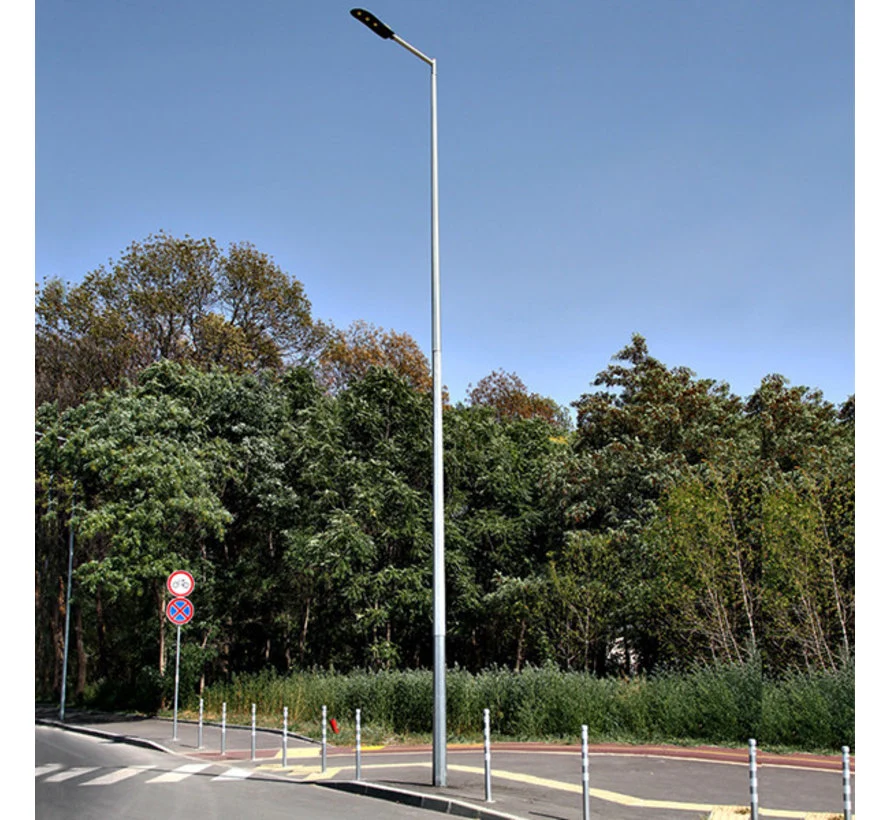

In [27]:
img = Image.open('/Users/florianterlinden/Desktop/HBO_ICT/velotech2_aai/Notebooks/lantaarnpaal_test_aan.webp')

# Preprocess input according to the functions specified above
img_data = preprocess(img)
img_size = np.array([img.size[1], img.size[0]], dtype=np.float32).reshape(1, 2)

# Look at what our input image looks like
img

In [28]:
# Now, let's predict using ONNX Runtime
start = time.time()
output = session.run(None, {"images": img_data})
end = time.time()

# Assuming the output tensor structure is as expected, you can access it directly
output_data = output[0]

# Check the shape of the output tensor
print("Output tensor shape:", output_data.shape)

# Update the unpacking based on the actual structure of the output tensor
if len(output_data.shape) == 3 and output_data.shape[2] == 6:
    # Assuming the last dimension is [x, y, width, height, score, class]
    boxes, scores, indices = output_data[:, :, :4], output_data[:, :, 4:5], output_data[:, :, 5:]
else:
    print("Error: Unexpected shape of the output tensor.")
    exit()

inference_time = np.round(end - start, 2)
print("Inference time: ", inference_time, " sec")

Output tensor shape: (1, 84, 8400)
Error: Unexpected shape of the output tensor.
Inference time:  0.1  sec


: 

In [13]:
print('Boxes:', boxes.shape)
print('Scores:', scores.shape)
print('Indices:', indices.shape)

Boxes: (1, 84, 4)
Scores: (1, 84, 1)
Indices: (1, 84, 8395)


In [15]:
def postprocess(boxes, scores, indices):
    objects_identified = indices.shape[1]  # Aangepast naar de juiste dimensie

    out_boxes, out_scores, out_classes = [], [], []

    if objects_identified > 0:
        for i in range(objects_identified):  # Itereer over de juiste dimensie
            # Geen 'classes' gedefinieerd, gebruik een generieke label
            out_classes.append("Lantaarnpaal")

            # Score voor deze detectie
            out_scores.append(scores[0, i, 0])

            # Indexen voor de begrenzingskistjes
            idx_1 = (0, i)
            out_boxes.append(boxes[idx_1])

        print(objects_identified, "Lantaarnpalen identified in source image.")
    else:
        print("Geen lantaarnpalen identified in source image.")

    return out_boxes, out_scores, out_classes, objects_identified

# Voorbeeldgebruik
out_boxes, out_scores, out_classes, objects_identified = postprocess(boxes, scores, indices)


84 Lantaarnpalen identified in source image.


In [16]:
def display_resultant_image_with_labels(image, boxes, scores, classes, image_name='result', threshold=0.5):
    img = np.array(image)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)

    # Filter boxen op basis van de drempelwaarde
    filtered_boxes = [boxes[i] for i in range(len(scores)) if scores[i] > threshold]
    filtered_classes = [classes[i] for i in range(len(scores)) if scores[i] > threshold]

    for bbox, obj_class in zip(filtered_boxes, filtered_classes):
        x, y, w, h = bbox
        color = 'blue'
        box_h = h
        box_w = w
        bbox = patches.Rectangle((x, y), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)

        # Voeg label toe aan de bounding box
        plt.text(x, y, obj_class, color='red', fontsize=12, backgroundcolor='blue')

    plt.axis('off')
    # Sla de afbeelding op
    plt.savefig("images/" + image_name + "-result.jpg", bbox_inches='tight', pad_inches=0.0)
    plt.show()

# Voorbeeldgebruik
display_resultant_image_with_labels(img, out_boxes, out_scores, out_classes, "lantaarnpaal_result")


FileNotFoundError: [Errno 2] No such file or directory: 'images/lantaarnpaal_result-result.jpg'

<Figure size 432x288 with 0 Axes>